# Mục Đích
> Trong bài này, chúng ta sẽ cố gắng áp dụng thêm CNN với RNN để tăng khả năng dự đoán của mô hình. Nếu coi toàn bộ một window là 1 khung tgian lớn để nhìn lại, thì CNN sẽ bổ sung thêm các khung thời gian nhỏ hơn, thông qua bộ filter để giúp RNN kết hợp các khoảng khung thời gian nhỏ với nhau lại trong môt window để đưa ra dự báo chính xác hơn.

In [ ]:
#default_exp tseries.tseries_with_cnn

In [ ]:
#export
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [ ]:
#hide
%matplotlib inline

# Quay lại ví dụ bài cũ
> Chúng ta sẽ quay lại với vị dụ trong 2 bài cũ để xem kết quả thực tế có cải thiện hơn không trước khi bắt đầu với dữ liệu thực tế.

## Tạo dữ liệu

In [ ]:
#export
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.figure(figsize=(10, 6))
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()
    
# hàm tạo xu hướng: đơn giản là hàm của thời gian nhân với tỷ lệ slope (tanh):   
def create_trend(times, slope=0):
    return times * slope

# Tạo xu tính chất vụ mùa:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

# Tạo dữ liệu có vụ mùa:
def create_seasonalities(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

# Tạo nhiễu:
def create_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed) # tạo seed
    return rnd.randn(len(time)) * noise_level

# Tạo autocorrelation:
def autocorrelation(time, amplitude, seed=None):
    phi=0.8
    rnd = np.random.RandomState(seed)
    array = rnd.randn(len(time) + 1)
    for i in range(1, len(time) + 1):
        array[i] += phi * array[i-1]
    return array[1:] * amplitude

def create_tfds(series, window_size=5, batch_size=32, shuffle_size=1000):
    """
        series: dữ liệu đầu vào dưới dạng series (numpy array/range)
        window_size: size của từng window view dữ liệu, ví dụ 5:  5 điểm thời gian liên tiếp
        batch_size: size của 1 batch bao gồm nhiều window: ví dụ 32: 32 chuối 5 điểm thời gian, dùng để train dữ liệu theo batch
        shuffle_size: size của 1 lần shuffle vị trí của các window.
    """
    # Biến đổi series thành tensorflow dataset:
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Tạo window:
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    # Trải phẳng:
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    # Tạo Xs, y:
    dataset = dataset.map(lambda o: (o[:-1], o[-1]))
    # xáo dữ liệu:
    dataset = dataset.shuffle(buffer_size=shuffle_size)
    # Tạo batch:
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

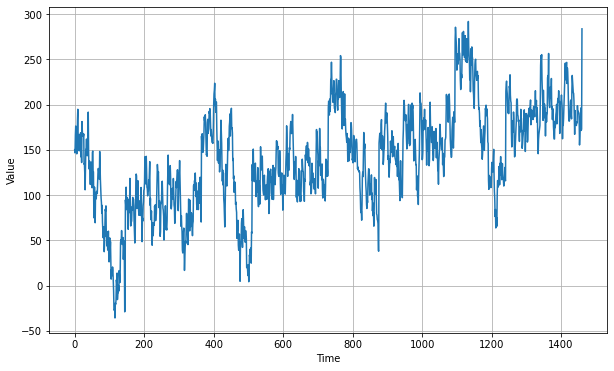

In [ ]:
#export
times = np.arange(4*365 + 1)
baseline = 50
tseries = baseline + create_trend(times, slope = 0.1)\
+ create_seasonalities(times, period=365, amplitude=100)\
+ create_noise(times, seed=42)\
+ autocorrelation(times, amplitude=15)
plot_series(times, tseries)

**Lưu ý:**

Trong bài trước, với dữ liệu array, chúng ta tạo tfds luôn qua phương pháp `tf.from_slice_tensors`. Tuy nhiên, đây là với dữ liệu đầu vào cho RNN. Với dữ liệu đầu vào của CNN, chúng ta cần tăng thêm dimension. Như vậy, dữ liệu mới của chúng ta sẽ là ma trận 2 chiều, thay vì array như với ví dụ của RNN.

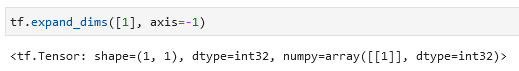

Chúng ta sẽ bổ sung thêm vào hàm `create_tfds` bằng cách tăng thêm dimension cho dữ liệu.

In [ ]:
#export
def create_tfds_new(series, window_size=5, batch_size=32, shuffle_size=1000):
    """
        series: dữ liệu đầu vào dưới dạng series (numpy array/range)
        window_size: size của từng window view dữ liệu, ví dụ 5:  5 điểm thời gian liên tiếp
        batch_size: size của 1 batch bao gồm nhiều window: ví dụ 32: 32 chuối 5 điểm thời gian, dùng để train dữ liệu theo batch
        shuffle_size: size của 1 lần shuffle vị trí của các window.
    """
    # Tăng size cho dữ liệu:
    series = tf.expand_dims(series, axis=-1)
    
    # Biến đổi series thành tensorflow dataset:
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Tạo window:
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    # Trải phẳng:
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    # Tạo Xs, y:
    dataset = dataset.map(lambda o: (o[:-1], o[-1]))
    # xáo dữ liệu:
    dataset = dataset.shuffle(buffer_size=shuffle_size)
    # Tạo batch:
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
#export
# Tạo dữ liệu:
window_size = 20
train_tfds = create_tfds_new(tseries[:3*365], window_size=window_size)
valid_tfds = create_tfds_new(tseries[3*365:], window_size=window_size)

In [ ]:
#hide
# Kiểm tra dữ liệu:
train_tfds

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>

In [ ]:
#hide
# Kiểm tra dữ liệu:
for tfds in train_tfds.take(1):
    print(tfds[0].numpy().shape)

(32, 20, 1)


**Lưu ý:**
Như vậy, chúng ta có thể thấy, dữ liệu đã là dạng 3-rank tensor thay vì 2-rank tensor như ban đầu với index 0 là size của batch, index 1 là window size, còn index cuối tương ứng từng giá trị trong một window.

## Tạo mô hình

### Kiểm thử lr
> Tương tự như bài trước, chúng ta sẽ chạy thử model với `lr_schedule` để tìm ra khoảng lr tốt nhất khi chạy thực tế.

In [ ]:
#export
keras.backend.clear_session()

In [ ]:
#export
model = keras.Sequential()

# Tạo layer Convolutional:
model.add(keras.layers.Conv1D(filters=32, kernel_size=5, padding='same', activation='relu', input_shape=[None, 1]))

# Tạo các layers Recurrent:
model.add(keras.layers.Bidirectional(keras.layers.LSTM(window_size*2, return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(window_size*2, return_sequences=True)))
model.add(keras.layers.Dense(1))
model.add(keras.layers.Lambda(lambda x: x * 100))

# Tạo lr scheduler:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

# Tạo optimizer:
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9, nesterov=True)

model.compile(optimizer=optimizer, loss=keras.losses.Huber(), metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 80)          23360     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 80)          38720     
_________________________________________________________________
dense (Dense)                (None, None, 1)           81        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 62,353
Trainable params: 62,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#export
model.fit(train_tfds, epochs=400, validation_data=valid_tfds, callbacks=[lr_schedule])

Epoch 1/400
34/34 [==============================] - 19s 225ms/step - loss: 111.1277 - mse: 14648.8252 - val_loss: 172.0798 - val_mse: 31640.2578
Epoch 2/400
34/34 [==============================] - 5s 128ms/step - loss: 107.0202 - mse: 13769.6172 - val_loss: 170.5641 - val_mse: 31128.3672
Epoch 3/400
34/34 [==============================] - 5s 125ms/step - loss: 105.5655 - mse: 13470.0436 - val_loss: 168.9689 - val_mse: 30595.7363
Epoch 4/400
34/34 [==============================] - 4s 123ms/step - loss: 102.4964 - mse: 12912.2100 - val_loss: 167.2701 - val_mse: 30034.7344
Epoch 5/400
34/34 [==============================] - 4s 124ms/step - loss: 103.7405 - mse: 13224.1056 - val_loss: 165.4339 - val_mse: 29435.2148
Epoch 6/400
34/34 [==============================] - 5s 125ms/step - loss: 98.9376 - mse: 12057.5205 - val_loss: 163.4325 - val_mse: 28790.3984
Epoch 7/400
34/34 [==============================] - 5s 139ms/step - loss: 97.1691 - mse: 11717.8108 - val_loss: 161.2201 - val_ms

**Lưu ý:**

Với kết quả training ở trên, chúng ta có thể thấy hiện tượng explosion của loss value khiến giá trị loss tăng lên với giá trị rất lớn.

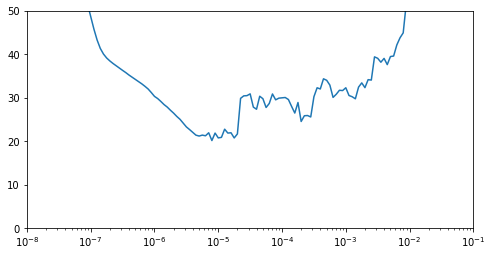

In [ ]:
#export
# Vẽ đồ thị learning rate và loss:
history = model.history
plt.figure(figsize=(8,4))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 50])
plt.show()

**Lưu ý:**
Chúng ta có thể thấy ở đây, lr ở khoảng 5e-6 và 5e-5 là khoảng mà loss bắt đầu giảm đến đáy trước khi tăng mạnh. Chúng ta sẽ chọn ngưỡng 1e-5 làm lr của chúng ta.

In [ ]:
#export
keras.backend.clear_session()
# Tạo layer Convolutional:
model = keras.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5, padding='same', activation='relu', input_shape=[None, 1])
    , keras.layers.Bidirectional(keras.layers.LSTM(window_size*2, return_sequences=True))
    , keras.layers.Bidirectional(keras.layers.LSTM(window_size*2, return_sequences=True))
    , keras.layers.Dense(1)
    , keras.layers.Lambda(lambda x: x * 100)
])
optimizer = keras.optimizers.SGD(learning_rate=5e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss=keras.losses.Huber(), metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 80)          23360     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 80)          38720     
_________________________________________________________________
dense (Dense)                (None, None, 1)           81        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 62,353
Trainable params: 62,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#export
model.fit(train_tfds, epochs=400, validation_data=valid_tfds)

Epoch 1/400
34/34 [==============================] - 10s 161ms/step - loss: 85.2133 - mse: 10978.3895 - val_loss: 64.1625 - val_mse: 5532.1157
Epoch 2/400
34/34 [==============================] - 5s 130ms/step - loss: 35.4481 - mse: 1998.1859 - val_loss: 62.0862 - val_mse: 5215.3271
Epoch 3/400
34/34 [==============================] - 5s 147ms/step - loss: 31.9810 - mse: 1683.1817 - val_loss: 57.2056 - val_mse: 4481.2812
Epoch 4/400
34/34 [==============================] - 4s 124ms/step - loss: 29.0642 - mse: 1404.8271 - val_loss: 47.0210 - val_mse: 3285.6401
Epoch 5/400
34/34 [==============================] - 4s 124ms/step - loss: 27.2383 - mse: 1255.4332 - val_loss: 43.8308 - val_mse: 2931.9585
Epoch 6/400
34/34 [==============================] - 5s 128ms/step - loss: 25.1242 - mse: 1077.0544 - val_loss: 38.8579 - val_mse: 2421.3088
Epoch 7/400
34/34 [==============================] - 5s 125ms/step - loss: 23.3363 - mse: 931.9447 - val_loss: 38.5342 - val_mse: 2335.5913
Epoch 8/400


KeyboardInterrupt: 

In [ ]:
#export
def plot_history(history, metrics:str='Accuracy'):
    item_dict = {'Loss': ['loss', 'val_loss'], f'{metrics}': [f'{metrics.lower()}', f'val_{metrics.lower()}']}
    plot_list = ['Loss', f'{metrics}']
    plt.figure(figsize=(8, 4))
    for i in range(len(plot_list)):
        plt.subplot(1, 2, i+1)
        item = plot_list[i]
        for items in item_dict[item]:
            plt.plot(history.history[items])
        plt.legend(item_dict[item])
    plt.tight_layout()

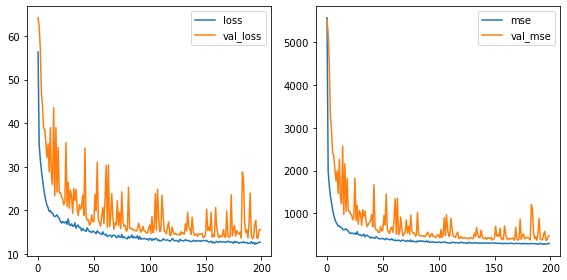

In [ ]:
#export
plot_history(model.history, metrics='mse')

**Vẽ so sánh kết quả:**

In [ ]:
#export
y_hat = model.predict(valid_tfds)

In [ ]:
#export
y_hat = y_hat.mean(axis=1)
y_hat = y_hat.reshape((346,))

In [ ]:
#export
y_true = []
for tfds in valid_tfds:
    y = tfds[1].numpy()
    for i in y:
        y_true.append(i[0])
y_true = np.array(y_true)
y_true.shape

(346,)

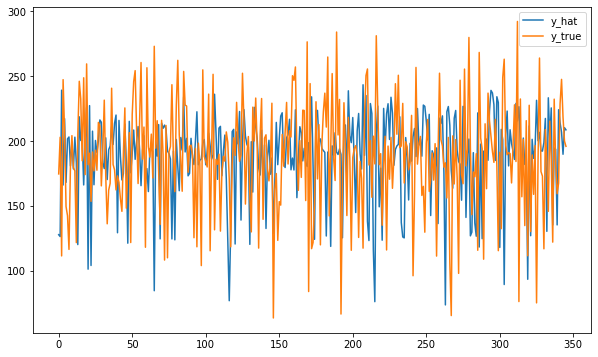

In [ ]:
#export
plt.figure(figsize=(10,6))
plt.plot(y_hat)
plt.plot(y_true)
plt.legend(['y_hat', 'y_true'])
plt.show()

# Dữ liệu thực tế
> Trong phần này chúng ta sẽ sử dụng dữ liệu thực tế từ [kaggle](https://www.kaggle.com/shenba/time-series-datasets?select=daily-minimum-temperatures-in-me.csv)

In [ ]:
#export
file_name = '~/git/TFExam/data//daily-minimum-temperatures-in-me.csv'

In [ ]:
#export
# df = pd.read_csv(file_name, header=None, skiprows=1, names=['date', 'temperature'], dtype=[str, np.float64])
df = pd.read_csv(file_name)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Date                        3650 non-null   object
 1   Daily minimum temperatures  3650 non-null   object
dtypes: object(2)
memory usage: 57.2+ KB


In [ ]:
#export
# Đổi tên cột:
df.columns = ['date', 'temp']

In [ ]:
#export
# Biến đổi dữ liệu
df.temp = df.temp.str.replace('?','')

<ipython-input-7-a744dc8f15e3>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.temp = df.temp.str.replace('?','')


In [ ]:
#export
# Biến đổi temperature sang dạng float:
df.temp = df.temp.astype(np.float64)
df.date = pd.to_datetime(df.date)

In [ ]:
#hide
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3650 non-null   datetime64[ns]
 1   temp    3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


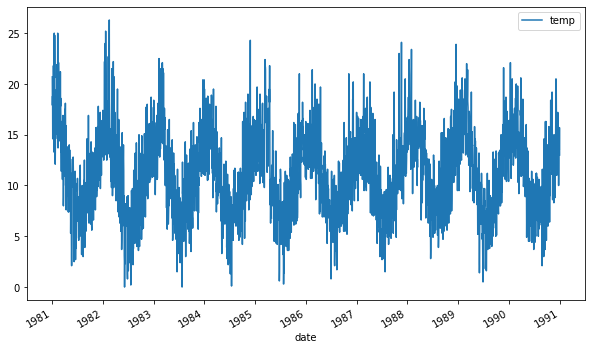

In [ ]:
#export
# Vẽ dữ liệu
df.plot(x='date', y='temp', figsize=(10,6))
plt.show()

**Lưu ý:**
Chúng ta có thể thấy ở đây dữ liệu mang tính seasonal rất cao, thường tăng từ đầu năm đến giữa năm rồi giảm ở cuối năm. Tất nhiên rồi, nhiệt độ tăng giảm theo các mùa trong năm, tăng dần từ tháng 1 và cao điểm vào các tháng 5,6,7 và giảm dần vào các tháng tiếp theo.

### Vài đặc điểm của dữ liệu

In [ ]:
#hide
df.temp.summary()

## Tạo dữ liệu
> Chúng ta có 10 năm dữ liệu. Chúng ta sẽ dùng dữ liệu từ năm 1981 đến năm 1989 làm dữ liệu của tập train, còn lại sẽ là dữ liệu của tập valid.

In [ ]:
#export
dtrain = df[df.date < '1990-01-01'].temp
dvalid = df[df.date >= '1990-01-01'].temp

In [ ]:
#hide
dtrain.shape, dvalid.shape

((3285,), (365,))

In [ ]:
#export
# Sử dụng window size là 1 tháng:
window_size = 30
train_tfds = create_tfds_new(dtrain, window_size=window_size)
valid_tfds = create_tfds_new(dvalid, window_size=window_size)

In [ ]:
#hide
train_tfds

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>

## Tạo mô hình

In [ ]:
#export
keras.backend.clear_session()
model = keras.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5, padding='same', activation='relu', input_shape=[None, 1])
    , keras.layers.Bidirectional(keras.layers.LSTM(window_size*2, return_sequences=True))
    , keras.layers.Bidirectional(keras.layers.LSTM(window_size*2, return_sequences=True))
    , keras.layers.Dense(1)
    , keras.layers.Lambda(lambda x: x * 10)
])
# Tạo lr scheduler:
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
opitmizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9, nesterov=True)
model.compile(optimizer=opitmizer, loss=keras.losses.Huber(), metrics=['mae', 'mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 120)         44640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 120)         86880     
_________________________________________________________________
dense (Dense)                (None, None, 1)           121       
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 131,833
Trainable params: 131,833
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#export
model.fit(train_tfds, epochs=200, validation_data=valid_tfds, callbacks=[lr_scheduler])

Epoch 1/200
102/102 [==============================] - 22s 116ms/step - loss: 14.3485 - mae: 14.8485 - mse: 237.0029 - val_loss: 14.6089 - val_mae: 15.1089 - val_mse: 242.2622
Epoch 2/200
102/102 [==============================] - 10s 98ms/step - loss: 14.2798 - mae: 14.7798 - mse: 234.9206 - val_loss: 14.5348 - val_mae: 15.0348 - val_mse: 239.9913
Epoch 3/200
102/102 [==============================] - 10s 99ms/step - loss: 14.2021 - mae: 14.7021 - mse: 232.5825 - val_loss: 14.4517 - val_mae: 14.9517 - val_mse: 237.4568
Epoch 4/200
102/102 [==============================] - 10s 99ms/step - loss: 14.1151 - mae: 14.6151 - mse: 229.9711 - val_loss: 14.3585 - val_mae: 14.8585 - val_mse: 234.6316
Epoch 5/200
102/102 [==============================] - 10s 98ms/step - loss: 14.0174 - mae: 14.5174 - mse: 227.0635 - val_loss: 14.2538 - val_mae: 14.7538 - val_mse: 231.4783
Epoch 6/200
102/102 [==============================] - 10s 101ms/step - loss: 13.9076 - mae: 14.4076 - mse: 223.8214 - val_l

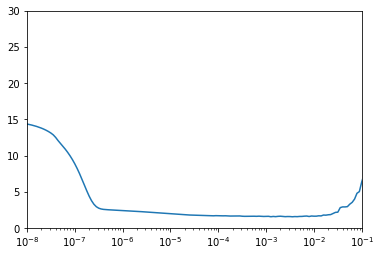

In [ ]:
#export
## Vẽ đồ thị giữa learning rate và loss:
history = model.history
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-1, 0, 30])
plt.show()

Chúng ta có thể thấy ở đây, lr bắt đầu chạy ngang từ khoảng 1e-5. Vậy nên chúng ta sẽ để lr ở khoảng này.

In [ ]:
#export
keras.backend.clear_session()
model = keras.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5, padding='same', activation='relu', input_shape=[None, 1])
    , keras.layers.Bidirectional(keras.layers.LSTM(window_size*2, return_sequences=True))
    , keras.layers.Bidirectional(keras.layers.LSTM(window_size*2, return_sequences=True))
    , keras.layers.Dense(1)
    , keras.layers.Lambda(lambda x: x * 10)
])
opitmizer = keras.optimizers.SGD(learning_rate=5e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=opitmizer, loss=keras.losses.Huber(), metrics=['mae', 'mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 120)         44640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 120)         86880     
_________________________________________________________________
dense (Dense)                (None, None, 1)           121       
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 131,833
Trainable params: 131,833
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#export
model.fit(train_tfds, epochs=200, validation_data=valid_tfds)

Epoch 1/200
102/102 [==============================] - 15s 109ms/step - loss: 3.7215 - mae: 4.1917 - mse: 31.0250 - val_loss: 2.3997 - val_mae: 2.8593 - val_mse: 13.3750
Epoch 2/200
102/102 [==============================] - 10s 101ms/step - loss: 2.4471 - mae: 2.9080 - mse: 13.9989 - val_loss: 2.2841 - val_mae: 2.7400 - val_mse: 12.3804
Epoch 3/200
102/102 [==============================] - 10s 100ms/step - loss: 2.3655 - mae: 2.8256 - mse: 13.2117 - val_loss: 2.2115 - val_mae: 2.6666 - val_mse: 11.7612
Epoch 4/200
102/102 [==============================] - 10s 99ms/step - loss: 2.3101 - mae: 2.7694 - mse: 12.6784 - val_loss: 2.1587 - val_mae: 2.6136 - val_mse: 11.3513
Epoch 5/200
102/102 [==============================] - 10s 100ms/step - loss: 2.2658 - mae: 2.7246 - mse: 12.2706 - val_loss: 2.1342 - val_mae: 2.5898 - val_mse: 10.9976
Epoch 6/200
102/102 [==============================] - 10s 100ms/step - loss: 2.2333 - mae: 2.6916 - mse: 11.9471 - val_loss: 2.0839 - val_mae: 2.5383 

Chúng ta có thể thấy ở đây, các chỉ số loss, mae, mse của train hiện đang vẫn cao hơn so với valid, điều này đồng nghĩa ta vẫn có thể tiếp tục train tiếp model cho đến khi các chỉ số này bắt đầu cao hơn so với tập valid để biết là model bắt đầu overfit (học vẹt).

In [ ]:
#export
def plot_history(history, metrics:str='Accuracy'):
    item_dict = {'Loss': ['loss', 'val_loss'], f'{metrics}': [f'{metrics.lower()}', f'val_{metrics.lower()}']}
    plot_list = ['Loss', f'{metrics}']
    plt.figure(figsize=(10, 6))
    for i in range(len(plot_list)):
        plt.subplot(1, 2, i+1)
        item = plot_list[i]
        for items in item_dict[item]:
            plt.plot(history.history[items])
        plt.legend(item_dict[item])
    plt.tight_layout()

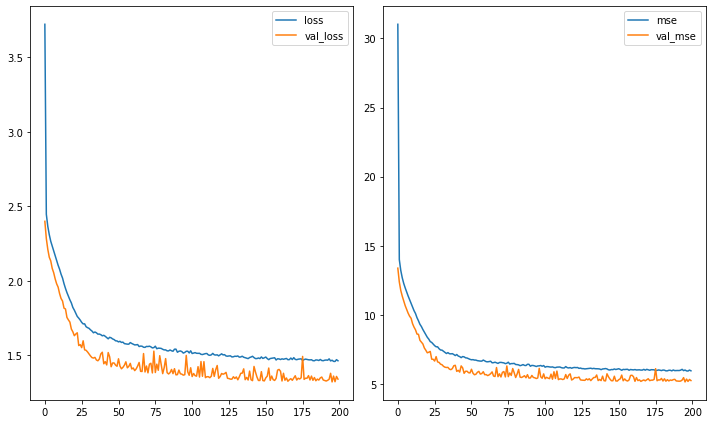

In [ ]:
#export
plot_history(model.history, metrics='mse')

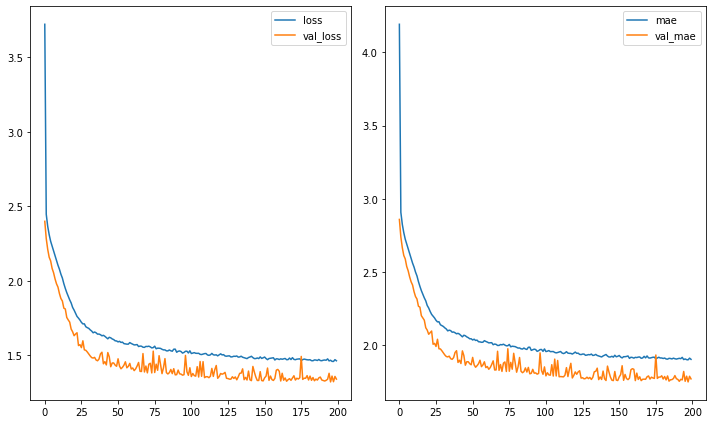

In [ ]:
#export
plot_history(model.history, metrics='mae')

**Lưu ý:**
Chúng ta có thể thấy ở đây cả mae và mse đểu khá là biến động nhiều trong tập valid hơn tập train rất nhiều. 

### Vẽ đồ thị kết quả

In [ ]:
#export
y_hat = model.predict(valid_tfds)
y_hat.shape

(335, 30, 1)

In [ ]:
#export
# Chúng ta sẽ lấy giá trị mean của y_hat làm giá trị prediction:
y_hat = y_hat.mean(axis=1)
y_hat = y_hat.reshape((335,))
y_hat[:10]

array([13.42943  ,  9.636172 ,  4.1361814,  7.1075764,  8.059246 ,
        7.4839954, 15.098821 ,  7.8449345, 13.43818  , 15.258244 ],
      dtype=float32)

In [ ]:
#export
y_true = []
for tfds in valid_tfds:
    y = tfds[1].numpy()
    for i in y:
        y_true.append(i)
y_true = np.array(y_true)
y_true.shape

(335, 1)

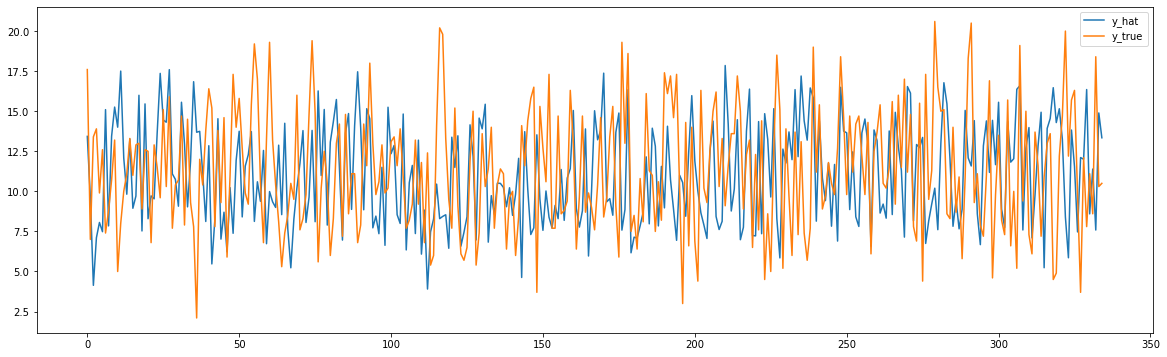

In [ ]:
#export
plt.figure(figsize=(20,6))
plt.plot(y_hat)
plt.plot(y_true)
plt.legend(['y_hat', 'y_true'])
plt.show()